In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('/content/resumes.csv')

In [3]:
print("Dataset Shape:", df.shape)
print("\nColumn Names:", df.columns)
print("\nFirst 5 Rows:\n", df.head())
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
print("\nNumber of Duplicate Resumes:", df['Data'].duplicated().sum())

Dataset Shape: (79, 2)

Column Names: Index(['Data', 'Role'], dtype='object')

First 5 Rows:
                                                 Data              Role
0    Anubhav Kumar Singh\t\t\n\n  To work in a gl...  Peoplesoft Admin
1  Profile Summary:\t\t\t\t\t\t\t\t\t\t\n7+ years...  Peoplesoft Admin
2  PeopleSoft Database Administrator\n           ...  Peoplesoft Admin
3  Murali\n\nExperience Summary \n\nI have 6 year...  Peoplesoft Admin
4  Priyanka Ramadoss\n61/46, MountPleasant, \nCoo...  Peoplesoft Admin

Data Types:
 Data    object
Role    object
dtype: object

Missing Values:
 Data    0
Role    0
dtype: int64

Number of Duplicate Resumes: 0


In [4]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [5]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [6]:
stop_words = set(stopwords.words('english') + list(string.punctuation))
lemmatizer = WordNetLemmatizer()

In [7]:
print("Initial Missing Values:\n", df.isnull().sum())
df = df.dropna(subset=['Data', 'Role'])
print("\nMissing Values After Cleaning:\n", df.isnull().sum())

Initial Missing Values:
 Data    0
Role    0
dtype: int64

Missing Values After Cleaning:
 Data    0
Role    0
dtype: int64


In [8]:
print("\nNumber of Duplicate Resumes:", df['Data'].duplicated().sum())
df = df.drop_duplicates(subset=['Data'])
print("Dataset Shape After Removing Duplicates:", df.shape)


Number of Duplicate Resumes: 0
Dataset Shape After Removing Duplicates: (79, 2)


In [9]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [10]:
df['cleaned_text'] = df['Data'].apply(clean_text)

In [11]:
df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))
short_resumes = df[df['word_count'] < 50]
print("\nNumber of Short Resumes (<50 words):", len(short_resumes))
if len(short_resumes) > 0:
    print("\nSample Short Resumes:\n", short_resumes[['Data', 'Role']].head())
df = df[df['word_count'] >= 50]
print("Dataset Shape After Removing Short Resumes:", df.shape)


Number of Short Resumes (<50 words): 0
Dataset Shape After Removing Short Resumes: (79, 4)


In [12]:
vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = vectorizer.fit_transform(df['cleaned_text'])
similarity_matrix = cosine_similarity(tfidf_matrix)
np.fill_diagonal(similarity_matrix, 0)
high_similarity_pairs = (similarity_matrix > 0.9).sum() / 2
print("\nNumber of Resume Pairs with >90% Similarity:", int(high_similarity_pairs))


Number of Resume Pairs with >90% Similarity: 4


In [13]:
indices_to_keep = []
for i in range(similarity_matrix.shape[0]):
    if i not in indices_to_keep:
        similar_indices = np.where(similarity_matrix[i] > 0.9)[0]
        indices_to_keep.append(i)
        similarity_matrix[similar_indices, :] = 0
df = df.iloc[indices_to_keep]
print("Dataset Shape After Removing Boilerplate Text:", df.shape)

Dataset Shape After Removing Boilerplate Text: (79, 4)


In [14]:
df['Role'] = df['Role'].str.strip().str.title()  # Capitalize for consistency
role_mapping = {
    'Peoplesoft Admin': 'Peoplesoft Admin',
    'Workday Hexaware': 'Workday Hexaware'
    # Add more mappings if needed
}
df['Role'] = df['Role'].replace(role_mapping)
print("\nUnique Roles After Standardization:\n", df['Role'].value_counts())


Unique Roles After Standardization:
 Role
Workday Hexaware      21
Sql Dev               14
React Dev             11
Reactjs Dev           11
Peoplesoft Admin       9
Peoplesoft Fscm        6
Peoplesoft Finance     3
React Dev Intern       2
Peoplesoft Dba         2
Name: count, dtype: int64


In [15]:
df.to_csv('resumes_cleaned.csv', index=False)
print("\nCleaned dataset saved as 'resumes_cleaned.csv'")


Cleaned dataset saved as 'resumes_cleaned.csv'


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [17]:
df = pd.read_csv('/content/resumes_cleaned.csv')

<ipython-input-18-e0f7a9c6b634>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(count, i, f'{role_percentages[i]:.1f}%', va='center')


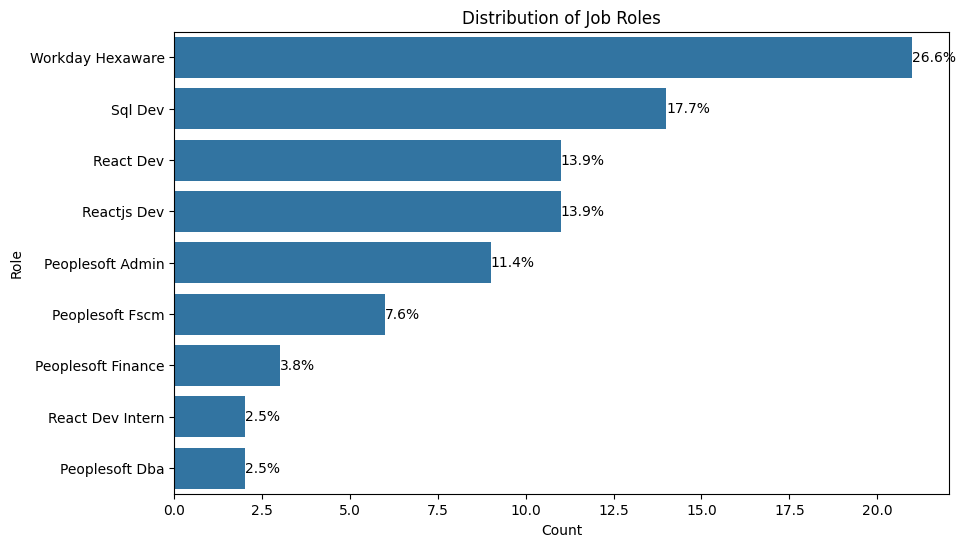

In [18]:
role_counts = df['Role'].value_counts()
role_percentages = df['Role'].value_counts(normalize=True) * 100
plt.figure(figsize=(10, 6))
sns.countplot(y='Role', data=df, order=role_counts.index)
plt.title('Distribution of Job Roles')
plt.xlabel('Count')
plt.ylabel('Role')
for i, count in enumerate(role_counts):
    plt.text(count, i, f'{role_percentages[i]:.1f}%', va='center')
plt.show()

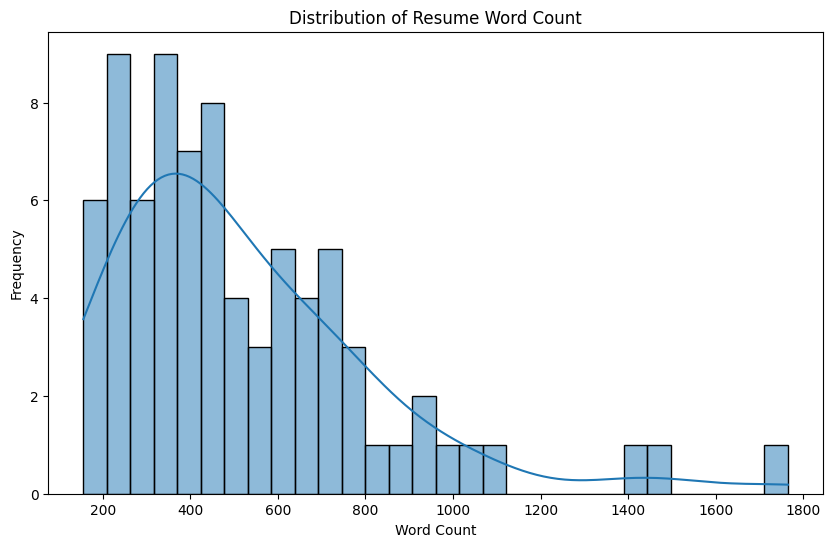

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=30, kde=True)
plt.title('Distribution of Resume Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

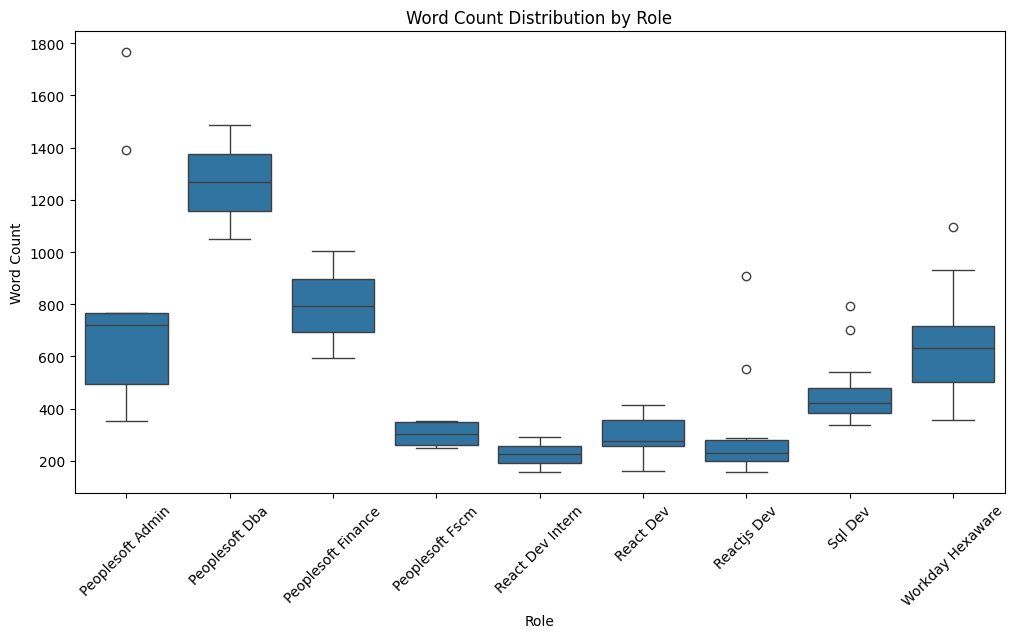

In [20]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Role', y='word_count', data=df)
plt.title('Word Count Distribution by Role')
plt.xticks(rotation=45)
plt.xlabel('Role')
plt.ylabel('Word Count')
plt.show()

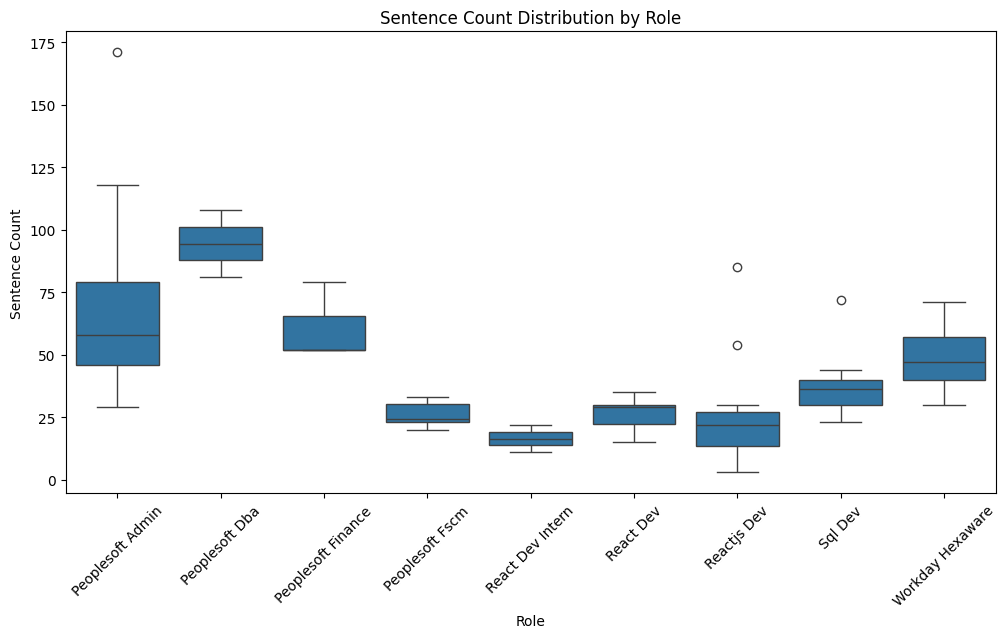

In [21]:
df['sentence_count'] = df['Data'].apply(lambda x: len(sent_tokenize(x)))
plt.figure(figsize=(12, 6))
sns.boxplot(x='Role', y='sentence_count', data=df)
plt.title('Sentence Count Distribution by Role')
plt.xticks(rotation=45)
plt.xlabel('Role')
plt.ylabel('Sentence Count')
plt.show()

In [22]:
def get_ngrams(text, n=2):
    tokens = word_tokenize(text)
    return [' '.join(gram) for gram in ngrams(tokens, n)]

all_bigrams = []
for text in df['cleaned_text']:
    all_bigrams.extend(get_ngrams(text, n=2))
bigram_freq = Counter(all_bigrams).most_common(20)

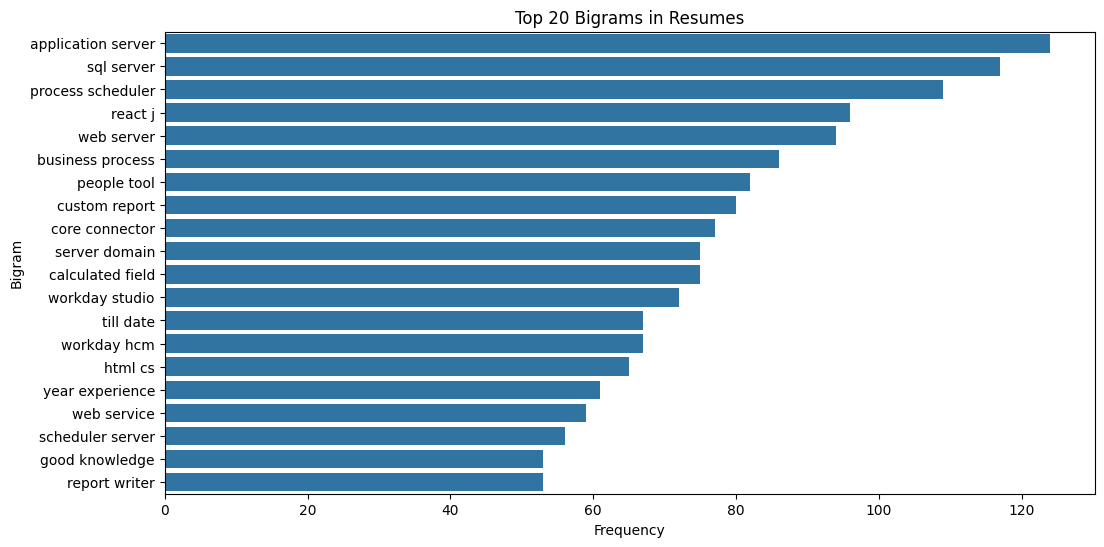

In [23]:
bigrams, counts = zip(*bigram_freq)
plt.figure(figsize=(12, 6))
sns.barplot(x=counts, y=bigrams)
plt.title('Top 20 Bigrams in Resumes')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.show()

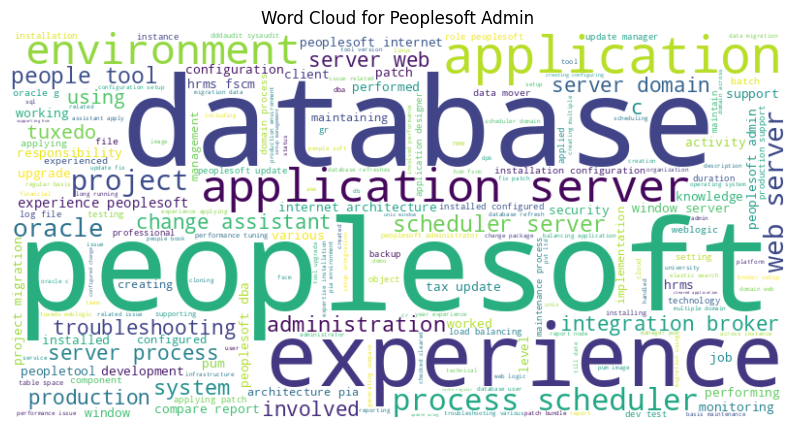

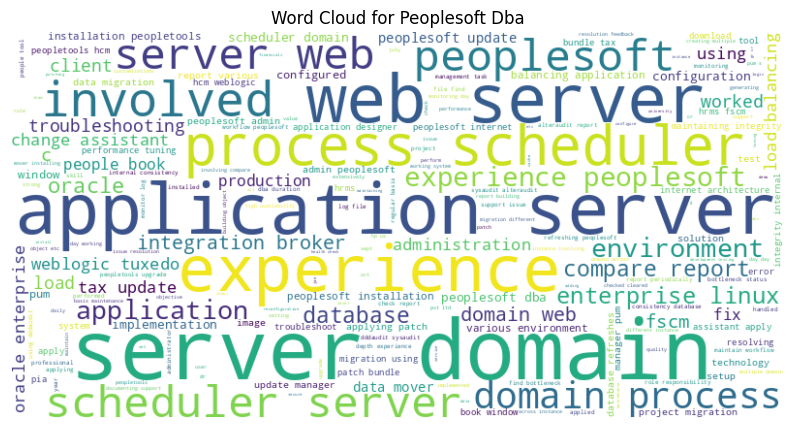

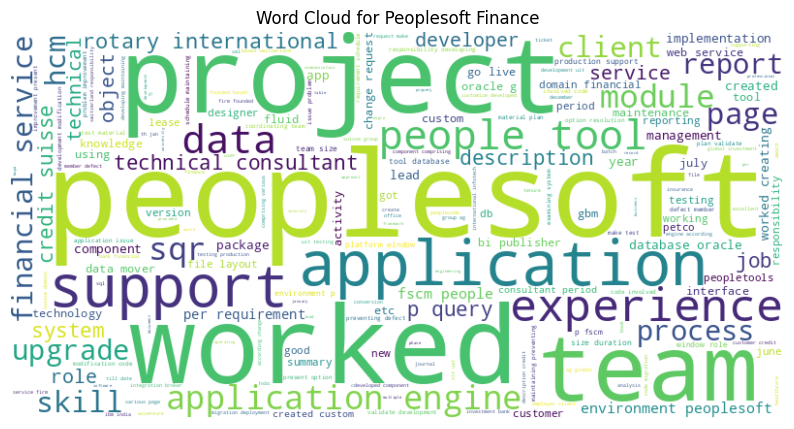

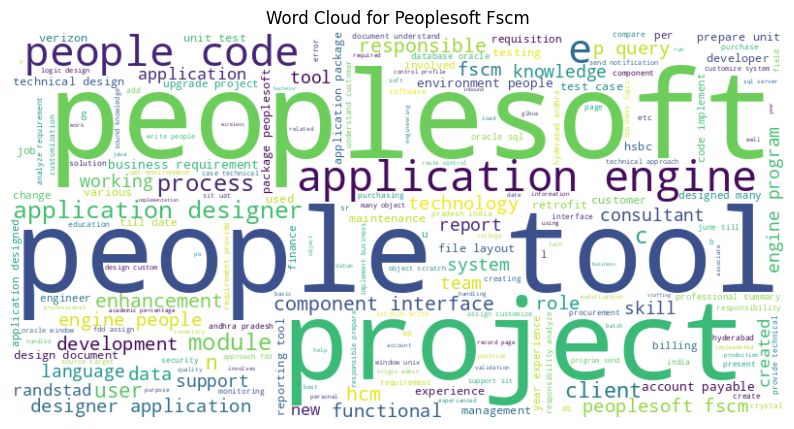

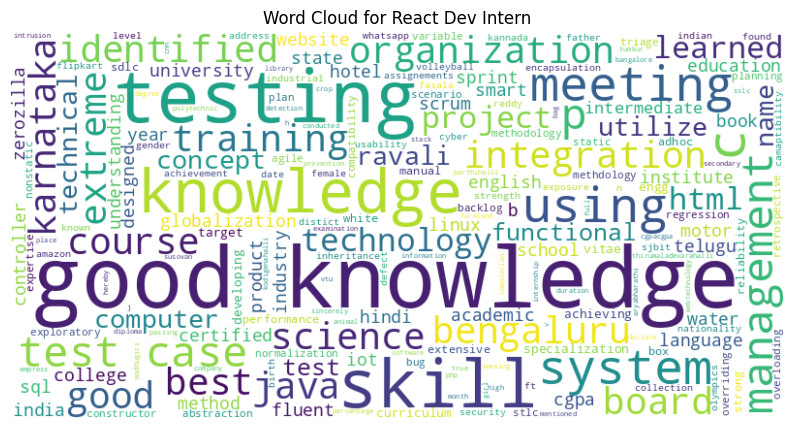

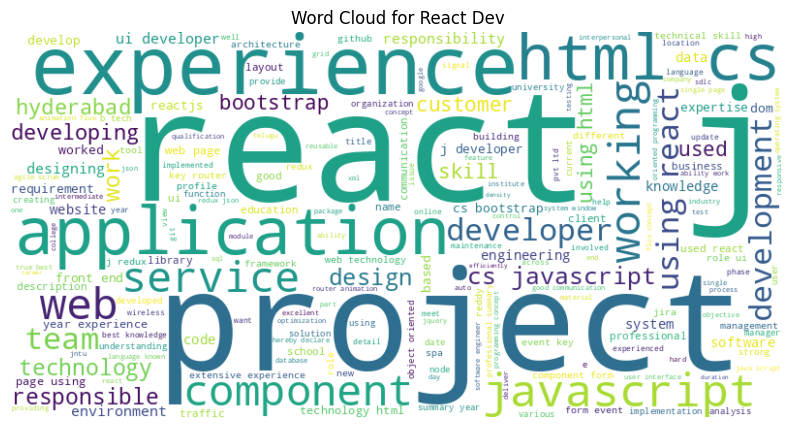

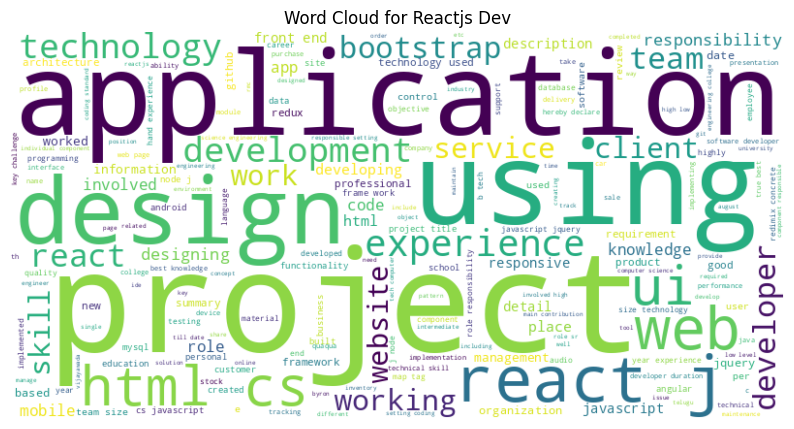

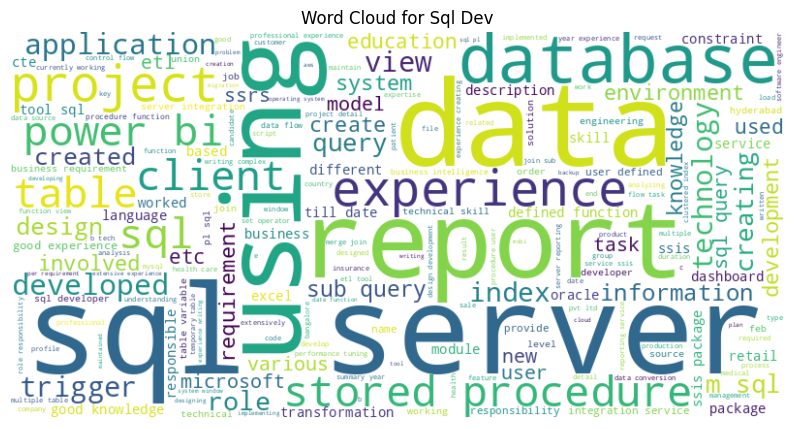

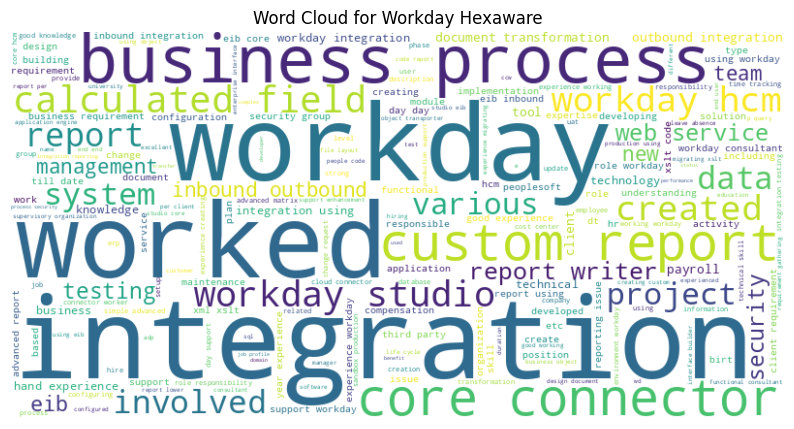

In [24]:
for role in df['Role'].unique():
    role_text = ' '.join(df[df['Role'] == role]['cleaned_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(role_text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {role}')
    plt.axis('off')
    plt.show()

In [25]:
vectorizer = TfidfVectorizer(max_features=100, ngram_range=(1, 2))
tfidf_matrix = vectorizer.fit_transform(df['cleaned_text'])
feature_names = vectorizer.get_feature_names_out()

In [26]:
def get_top_tfidf_keywords(role, n=10):
    role_indices = df[df['Role'] == role].index
    role_tfidf = tfidf_matrix[role_indices].mean(axis=0).A1
    top_indices = role_tfidf.argsort()[-n:][::-1]
    return [(feature_names[i], role_tfidf[i]) for i in top_indices]

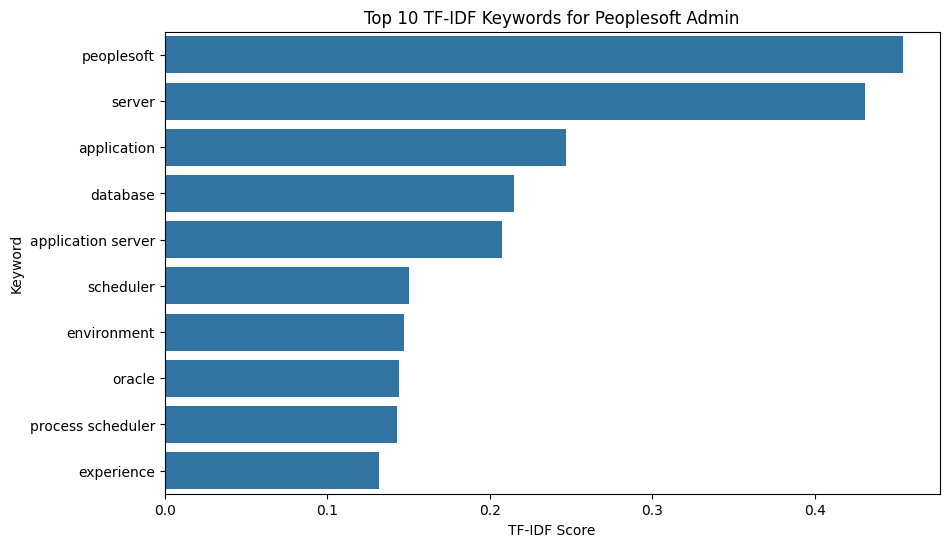

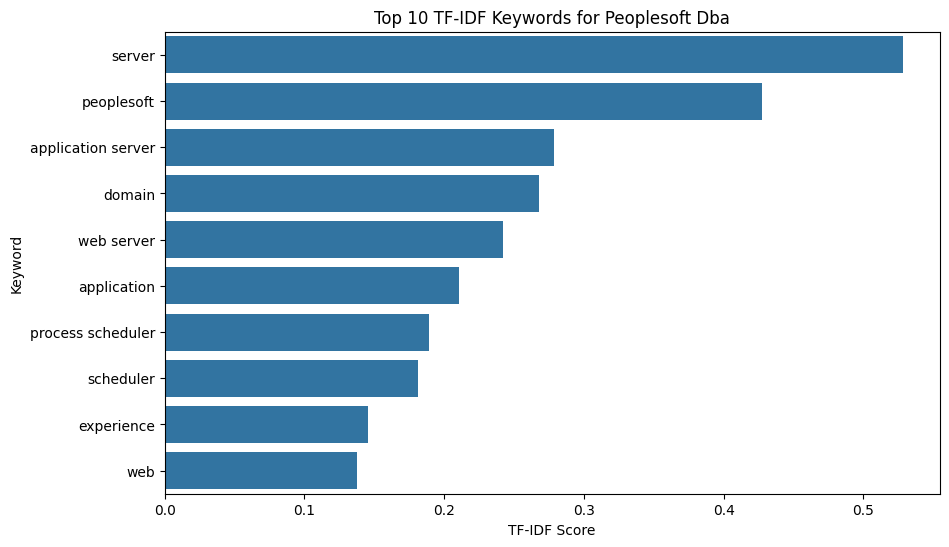

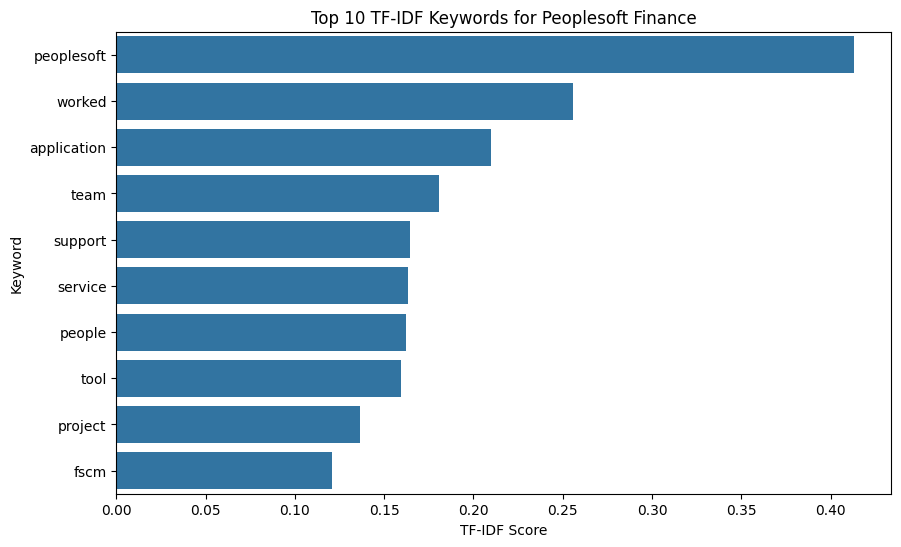

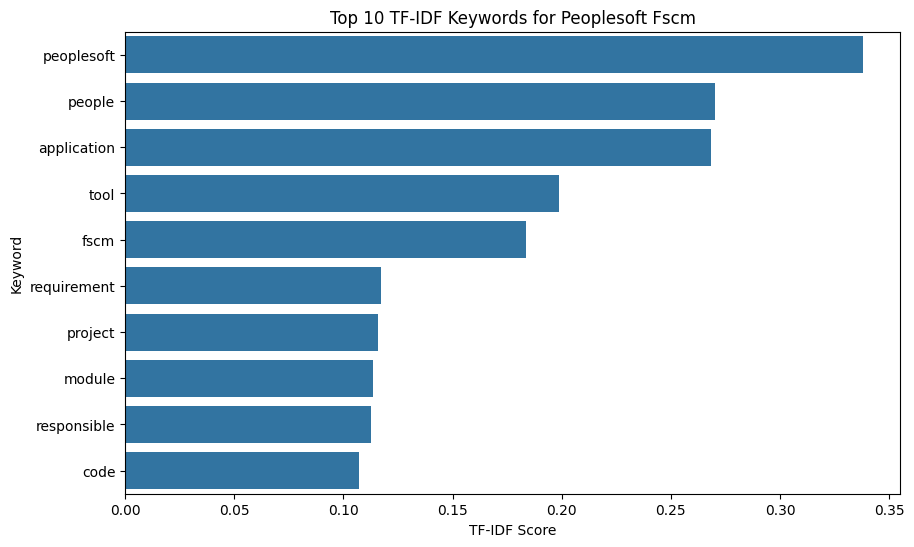

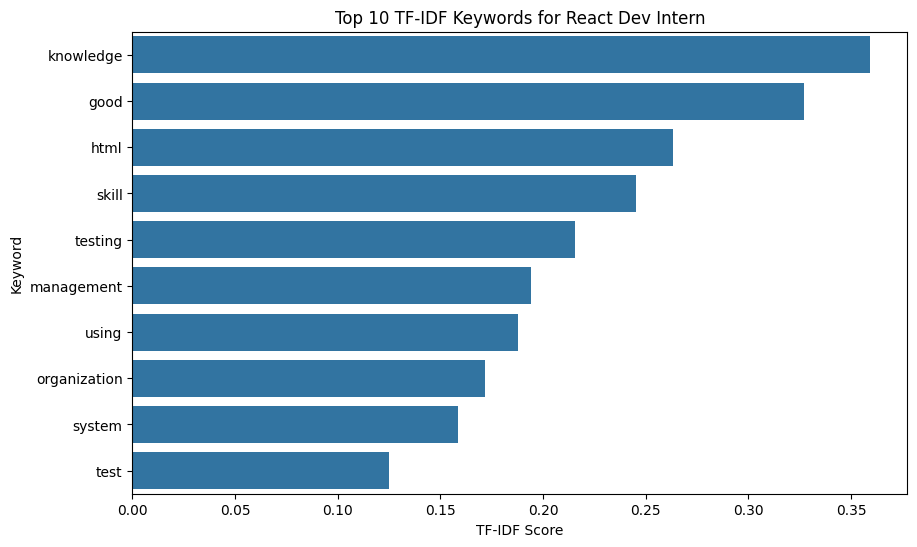

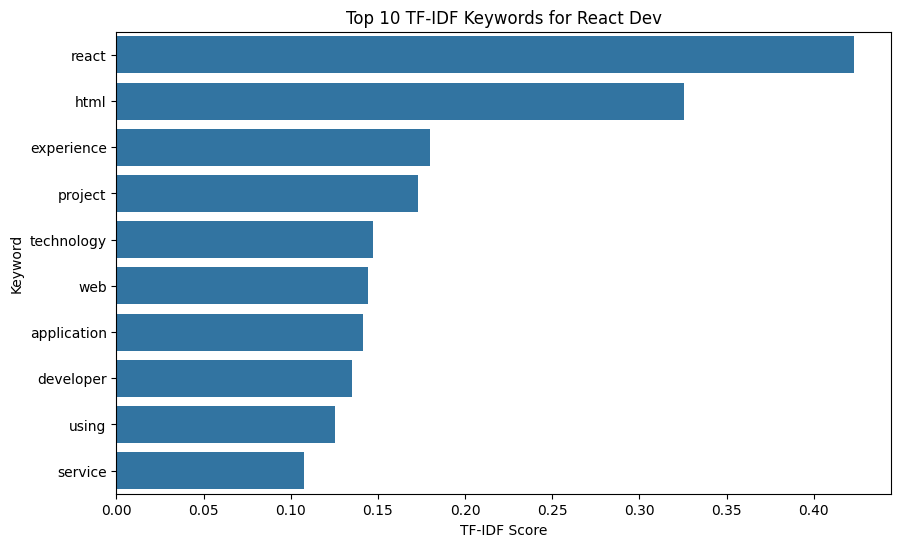

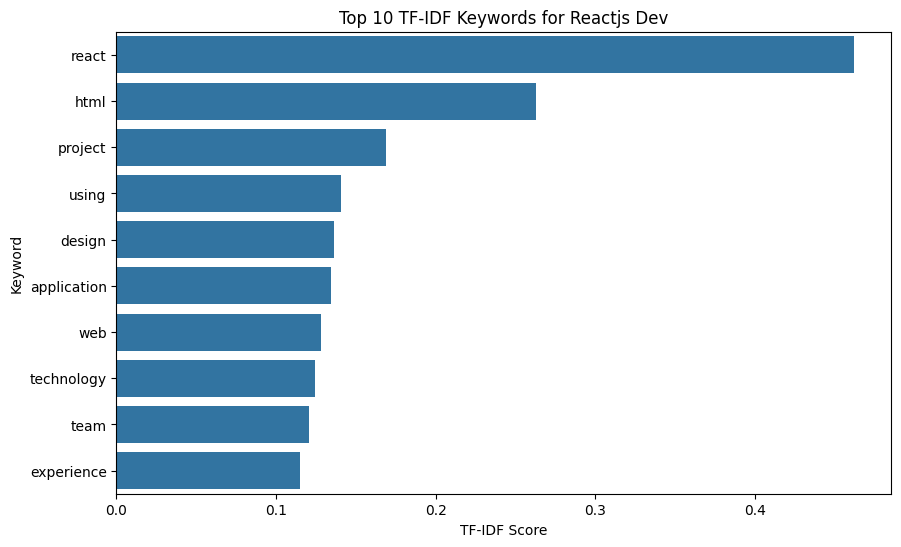

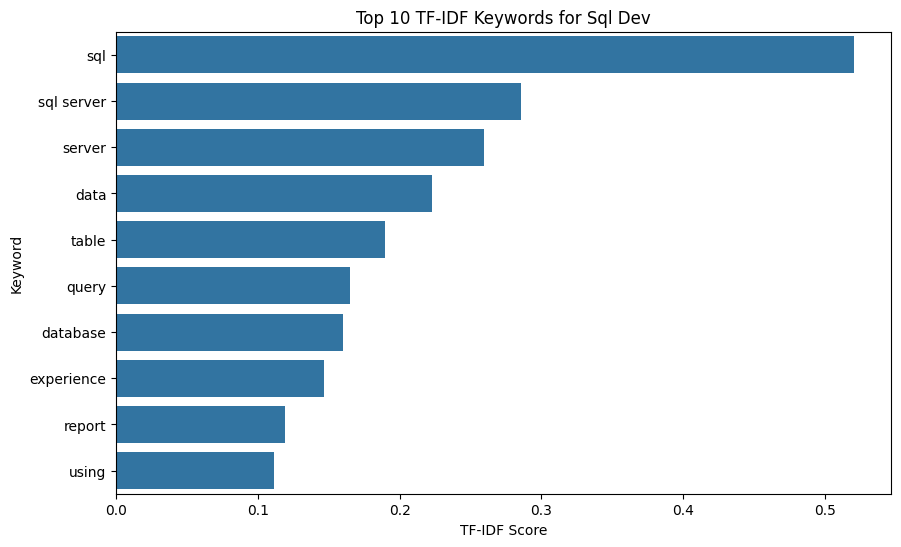

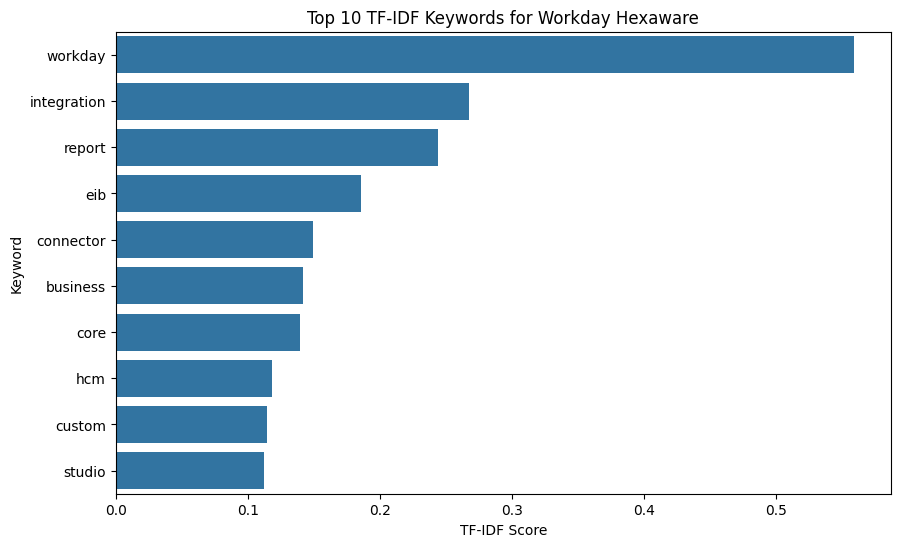

In [27]:
for role in df['Role'].unique():
    keywords, scores = zip(*get_top_tfidf_keywords(role))
    plt.figure(figsize=(10, 6))
    sns.barplot(x=scores, y=keywords)
    plt.title(f'Top 10 TF-IDF Keywords for {role}')
    plt.xlabel('TF-IDF Score')
    plt.ylabel('Keyword')
    plt.show()

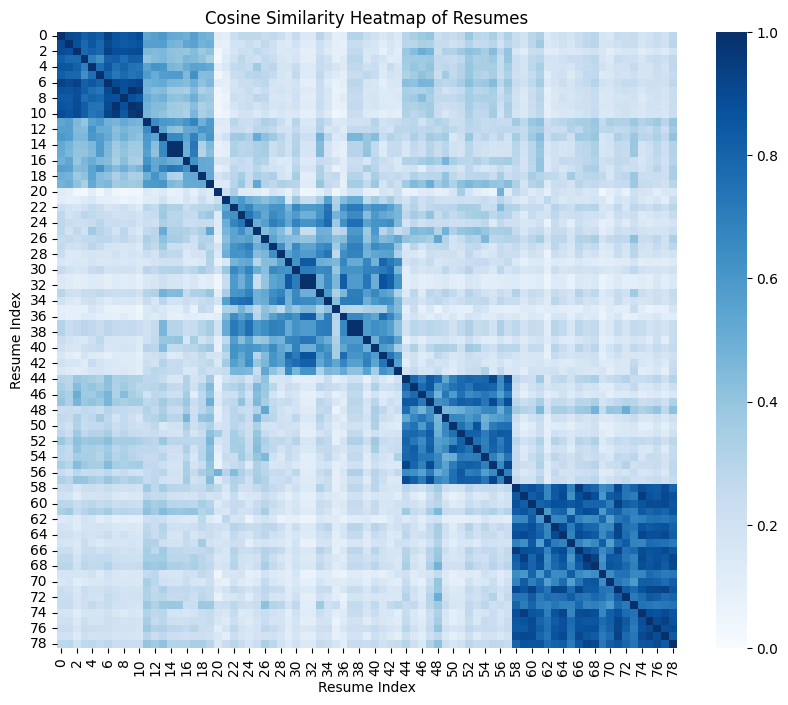

In [28]:
similarity_matrix = cosine_similarity(tfidf_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='Blues', vmin=0, vmax=1)
plt.title('Cosine Similarity Heatmap of Resumes')
plt.xlabel('Resume Index')
plt.ylabel('Resume Index')
plt.show()

In [29]:
!pip install textstat


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.5 MB/s eta 0:00:00


In [30]:
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
from textstat import flesch_kincaid_grade
from textblob import TextBlob
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [31]:
df = pd.read_csv('/content/resumes_cleaned.csv')

In [32]:
df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))
df['sentence_count'] = df['Data'].apply(lambda x: len(sent_tokenize(x)))
df['avg_sentence_length'] = df['word_count'] / df['sentence_count'].replace(0, 1)

In [33]:
df['readability'] = df['Data'].apply(flesch_kincaid_grade)

In [34]:
keywords = {
    'Peoplesoft Admin': ['tuxedo', 'weblogic', 'pum', 'integration broker', 'application server'],
    'Workday Hexaware': ['eib', 'studio', 'calculated fields', 'core connector', 'picof']
}
for role, kw_list in keywords.items():
    for kw in kw_list:
        df[f'kw_{kw}'] = df['cleaned_text'].apply(lambda x: x.count(kw))

In [35]:
df['sentiment'] = df['Data'].apply(lambda x: TextBlob(x).sentiment.polarity)

def extract_experience_years(text):
    years = re.findall(r'\b(19\d{2}|20\d{2})\b', text)
    if len(years) >= 2:
        years = [int(y) for y in years]
        return max(years) - min(years)
    return 0
df['experience_years'] = df['Data'].apply(extract_experience_years)

In [36]:
technical_terms = sum(keywords.values(), [])
df['technical_term_density'] = df['cleaned_text'].apply(
    lambda x: sum(x.count(term) for term in technical_terms) / len(x.split()) if len(x.split()) > 0 else 0
)

In [37]:
df.to_csv('resumes_features.csv', index=False)
print("\nDataset with new features saved as 'resumes_features.csv'")


Dataset with new features saved as 'resumes_features.csv'


In [38]:
le = LabelEncoder()
df['Role_encoded'] = le.fit_transform(df['Role'])

In [39]:
numeric_cols = ['word_count', 'sentence_count', 'avg_sentence_length', 'readability', 'sentiment', 'experience_years', 'technical_term_density'] + \
               [col for col in df.columns if col.startswith('kw_')]
correlation = df[numeric_cols + ['Role_encoded']].corr()['Role_encoded'].sort_values()
print("\nCorrelation with Role:\n", correlation)


Correlation with Role:
 kw_application server    -0.592434
kw_pum                   -0.563743
kw_weblogic              -0.555095
kw_tuxedo                -0.552839
kw_integration broker    -0.524500
experience_years         -0.278410
sentence_count           -0.271236
word_count               -0.197393
technical_term_density   -0.002170
sentiment                 0.051928
avg_sentence_length       0.092122
readability               0.275722
kw_picof                  0.343584
kw_core connector         0.501531
kw_studio                 0.524482
kw_eib                    0.561289
Role_encoded              1.000000
kw_calculated fields           NaN
Name: Role_encoded, dtype: float64


In [40]:
X = df[numeric_cols]
y = df['Role']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

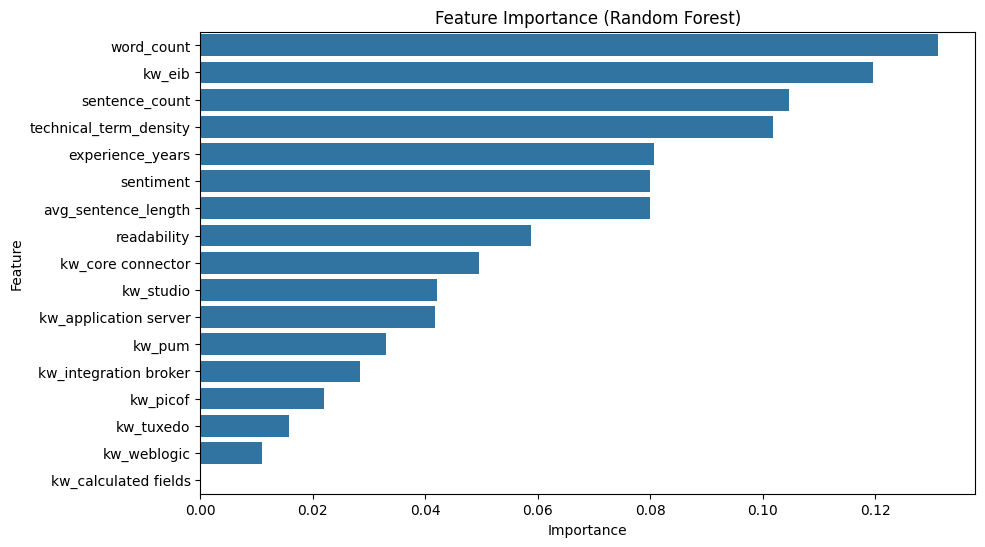

In [43]:
feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [44]:
y_pred = rf.predict(X_test)
print("\nClassification Report with New Features:\n", classification_report(y_test, y_pred))


Classification Report with New Features:
                     precision    recall  f1-score   support

  Peoplesoft Admin       1.00      0.50      0.67         2
    Peoplesoft Dba       1.00      1.00      1.00         1
Peoplesoft Finance       0.00      0.00      0.00         1
   Peoplesoft Fscm       0.00      0.00      0.00         1
         React Dev       1.00      0.50      0.67         4
       Reactjs Dev       0.33      0.50      0.40         2
           Sql Dev       0.33      1.00      0.50         2
  Workday Hexaware       1.00      1.00      1.00         3

          accuracy                           0.62        16
         macro avg       0.58      0.56      0.53        16
      weighted avg       0.71      0.62      0.61        16



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [45]:
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df['cleaned_text']) # Corrected method name to fit_transform
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
rf_tfidf = RandomForestClassifier(random_state=42)
rf_tfidf.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf = rf_tfidf.predict(X_test_tfidf)
print("\nClassification Report with TF-IDF Features:\n", classification_report(y_test_tfidf, y_pred_tfidf))


Classification Report with TF-IDF Features:
                     precision    recall  f1-score   support

  Peoplesoft Admin       0.67      1.00      0.80         2
    Peoplesoft Dba       0.00      0.00      0.00         1
Peoplesoft Finance       0.00      0.00      0.00         1
   Peoplesoft Fscm       0.50      1.00      0.67         1
         React Dev       0.50      0.50      0.50         4
       Reactjs Dev       0.00      0.00      0.00         2
           Sql Dev       1.00      1.00      1.00         2
  Workday Hexaware       1.00      1.00      1.00         3

          accuracy                           0.62        16
         macro avg       0.46      0.56      0.50        16
      weighted avg       0.55      0.62      0.58        16



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
